### Two datasets with a similar motif

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import multibind as mb
import numpy as np
import pandas as pd

import torch
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [ ]:
train1, test1 = mb.tl.create_multi_data(n_chip=50, n_selex=50)

### Using cooptf/screr (this will be deprecated and replace by bindome).

### If treating y data as log, the convergence gets to the GATA motif in small sequences.

In [ ]:
train1.dataset.target = np.log(train1.dataset.target)

In [ ]:
df = pd.DataFrame()
df['y'] = train1.dataset.target
df['batch'] = np.array(train1.dataset.batch)
sns.boxplot(data=df, x='batch', y='y')

In [ ]:
net2 = mb.models.DinucMulti(use_dinuc=False, n_datasets=2, w=7).to(device)
net2.dataset.weight.data.uniform_(1, 1) # initialize weights as ones.

In [ ]:
mononuc = torch.Tensor(train1.dataset.mononuc).to(device)
dinuc = torch.Tensor(train1.dataset.dinuc).to(device)
b = torch.Tensor(train1.dataset.batch).to(torch.int64)
y_true = torch.Tensor(train1.dataset.target)

inputs = (mononuc, dinuc, b)
y_pred = net2(inputs).detach().numpy()

In [ ]:
torch.Tensor(train1.dataset.dinuc)

In [ ]:
# train1.dataset.batch.shape, train1.dataset.mononuc.shape
net2.conv_di(torch.unsqueeze(torch.Tensor(train1.dataset.dinuc), 1))[0].squeeze()

In [ ]:
# train1.dataset.batch.shape, train1.dataset.mononuc.shape
net2.conv_mono(torch.unsqueeze(torch.Tensor(train1.dataset.mononuc), 1))[0].squeeze()

In [ ]:
optimiser = topti.Adam(net2.parameters(), lr=0.001, weight_decay=0.0001)
criterion = mb.tl.PoissonLoss()
l2 = []
l2 += mb.tl.train_network(net2, train1, device, optimiser, criterion, num_epochs=5000, log_each=100)

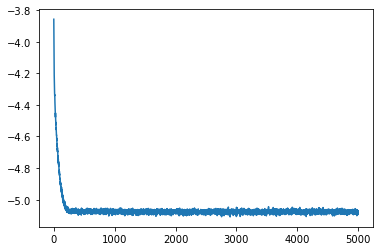

In [10]:
plt.plot(l2)

In [11]:
## check the batch effects
net2.dataset.weight

Parameter containing:
tensor([[0.2870],
        [1.0118],
        [1.3720]], requires_grad=True)

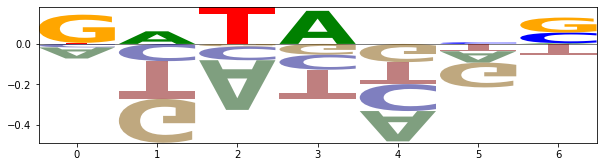

In [12]:
# print(np.exp(net2.log_weight_1.squeeze().cpu().detach().numpy()))
# print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
#mb.tl.create_logo(net)
#plt.show()
#mb.tl.create_heatmap(net)
import logomaker
weights = net2.conv_mono.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [13]:
from sklearn.metrics import r2_score

In [14]:
net2.dataset.weight

Parameter containing:
tensor([[0.2870],
        [1.0118],
        [1.3720]], requires_grad=True)

### Check the quality of the predictions, across datasets

In [15]:
mononuc = torch.Tensor(train1.dataset.mononuc).to(device)
dinuc = torch.Tensor(train1.dataset.dinuc).to(device)
b = torch.Tensor(train1.dataset.batch).to(torch.int64)
y_true = torch.Tensor(train1.dataset.target)
inputs = (mononuc, dinuc, b)
y_pred = net2(inputs).detach().numpy()

In [16]:
mononuc[0].shape

torch.Size([4, 14])

In [17]:
r2_score(y_true, y_pred)

0.9908430600512479

Text(0, 0.5, 'predicted')

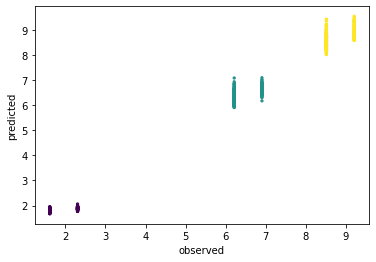

In [18]:
plt.scatter(y_true, y_pred, s=5, c=b)
plt.xlabel('observed')
plt.ylabel('predicted')

In [19]:
print('here...')

here...
